In [13]:
from collections import defaultdict
from itertools import product
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon

PRED_PATH = Path().resolve() / "ax_runs" / "prediction"
STFS_PATH = Path().resolve() / "ax_runs" / "st_selection"
PLOT_PATH = Path().resolve() / "plots"

##### Plot 1: Regression performance

In [14]:
! pip install git+https://github.com/jhultman/matplotlib-curly-brace

  Cloning https://github.com/jhultman/matplotlib-curly-brace to /tmp/pip-req-build-tnt7i_fz
  Running command git clone --filter=blob:none --quiet https://github.com/jhultman/matplotlib-curly-brace /tmp/pip-req-build-tnt7i_fz
  Resolved https://github.com/jhultman/matplotlib-curly-brace to commit 2a757496756080ca683f618d3afdd480dd814989
  Preparing metadata (setup.py) ... done


1.0
-1.0
0.5


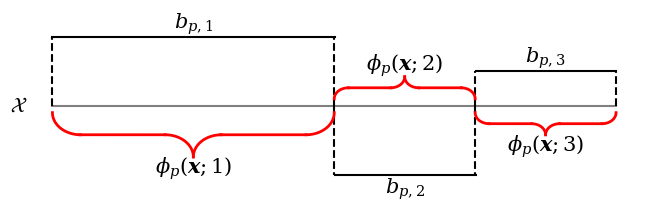

In [21]:
from curlyBrace import curlyBrace
from matplotlib import rc_context

fig, axs = plt.subplots(1, 1, figsize=(8, 2.5), sharey=True, sharex=True)

x = np.linspace(-1, 1, endpoint=True, num=1000)

cutoffs = np.array([-1, 0, 1 / 2, 1])
values = np.array([1, -1, 1 / 2])
directions = ["up", "down", "up"]

axs.plot([-1, 1], [0, 0], color="k", alpha=0.5)

for i in range(1, len(cutoffs)):
    offset = x[1] - x[0]
    x_vals = x[(x >= cutoffs[i - 1]) & (x - offset <= cutoffs[i])]
    y_vals = np.full_like(x_vals, values[i - 1])

    axs.plot(x_vals, y_vals, color="k")

    bounds = [cutoffs[i - 1], cutoffs[i]]
    axs.vlines(bounds, 0, values[i - 1], color="k", linestyle="--")

font_dict = {
    "color": "k",
    "family": "serif",
    "size": 15,
}

with rc_context({"mathtext.fontset": "dejavuserif"}):
    for i, (start, end, direction) in enumerate(
        zip(cutoffs[:-1], cutoffs[1:], directions)
    ):
        offset = 0.1
        scale = 0.1

        signed_offset = -offset if direction == "up" else offset

        if direction == "up":
            p1 = (start, signed_offset)
            p2 = (end, signed_offset)
        else:
            p1 = (end, signed_offset)
            p2 = (start, signed_offset)

        curlyBrace(
            fig=fig,
            ax=axs,
            p2=p1,
            p1=p2,
            k_r=scale,
            str_text="$\\phi_p(\\boldsymbol{x};" + str(i + 1) + ")$",
            color="r",
            lw=2,
            int_line_num=1,
            fontdict=font_dict,
        )

        center = (start + end) / 2
        axs.annotate(
            "$b_{p," + str(i + 1) + "}$",
            (center, values[i] - 2 * signed_offset),
            ha="center",
            va="center",
            **font_dict,
        )
        print(values[i])

    offset = 1 / 10
    axs.set_ylim(-1 - 4 * offset, 1 + 4 * offset)

    axs.set_xticks([])
    axs.set_yticks([])
    axs.spines[["right", "top", "left", "bottom"]].set_visible(False)
    axs.set_ylabel(
        "$\mathcal{X}$",
        rotation=0,
        va="center",
        **font_dict,
    )

plt.savefig("plots/poster_tree_diagram.pdf", bbox_inches="tight")

plt.show()